# Customer Segmentation

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_c_train_fe = pd.read_pickle('data/df_c_train_fe.pkl')
df_customers = pd.read_csv('data/customers.csv')

In [133]:
# drop NA values and non-useful columns
cleaned_customers_df = df_customers.dropna(
    subset=["customer_id", "postal_code", "age", "fashion_news_frequency", "club_member_status"]).drop(columns=["FN", "postal_code", "club_member_status", "Active"])

# change "NONE" and "nan" values to "None"
cleaned_customers_df["fashion_news_frequency"] = df_customers["fashion_news_frequency"].replace({"NONE": "None", "None": "None"})

In [134]:
# merge df_c_train_fe with cleaned_customers_df to get age
df_c_train_fe = pd.merge(cleaned_customers_df, df_c_train_fe, on='customer_id', how='inner')

In [135]:
print("Head of df_c_train_fe:")
df_c_train_fe.head()

Head of df_c_train_fe:


,customer_id,fashion_news_frequency,age,total_spent,spending_power,preferred_products,preferred_colors,preferred_perceived_colors,combined_preferences,combined_preferences_embeddings,avg_time_diff_btw_purchase,hours_between_purchases,total_transactions,avg_spent,max_spent,trend_score,log_trend_score,diversity_score
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,None,49.0,0.111814,Medium,Garment Upper body,Black,Dark,"Garment Upper body, Black, Dark","[-0.16557673, 0.12581567, 0.18150374, -0.09454...",11 days 12:00:00,276.0,3,0.037271,0.050831,0.000316,-8.060959,0.152843
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,None,25.0,0.782712,High,Garment Upper body,Black,Dark,"Garment Upper body, Black, Dark","[-0.16557673, 0.12581567, 0.18150374, -0.09454...",3 days 10:06:18.947368421,82.0,20,0.039136,0.084729,0.000197,-8.531776,0.345287
2,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,None,54.0,0.060983,Medium,Underwear,Black,Dark,"Underwear, Black, Dark","[-0.2277323, 0.51116055, 0.020547291, 0.149339...",0 days 00:00:00,8760.0,2,0.030492,0.030492,0.000082,-9.407381,0.000947
3,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,None,20.0,0.042339,Low,Swimwear,Dark Green,Medium Dusty,"Swimwear, Dark Green, Medium Dusty","[0.08616607, -0.1816099, 0.25200048, -0.060982...",0 days 00:00:00,8760.0,2,0.021169,0.025407,0.000269,-8.219498,0.071792
4,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,Regularly,56.0,0.772729,High,Garment Upper body,Black,Dark,"Garment Upper body, Black, Dark","[-0.16557673, 0.12581567, 0.18150374, -0.09454...",1 days 21:31:02.068965517,46.0,30,0.025758,0.065881,0.000111,-9.109974,0.155789


In [136]:
norm_unique_values_counts = df_c_train_fe['hours_between_purchases'].value_counts()
print(norm_unique_values_counts)

hours_between_purchases
8760.0    237556
24.0        5016
48.0        4359
72.0        3986
96.0        3445
           ...  
592.0         11
1632.0        10
1728.0         7
1776.0         4
1752.0         4
Name: count, Length: 384, dtype: int64


### Scale "total_spent" ready for clustering
1. Reduce Skew
2. Ensure scale of expenditures do not dominate

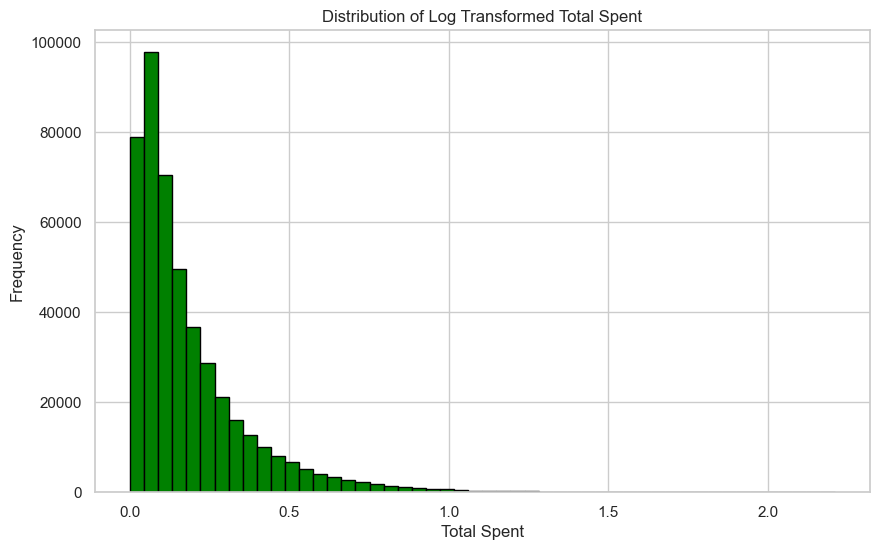

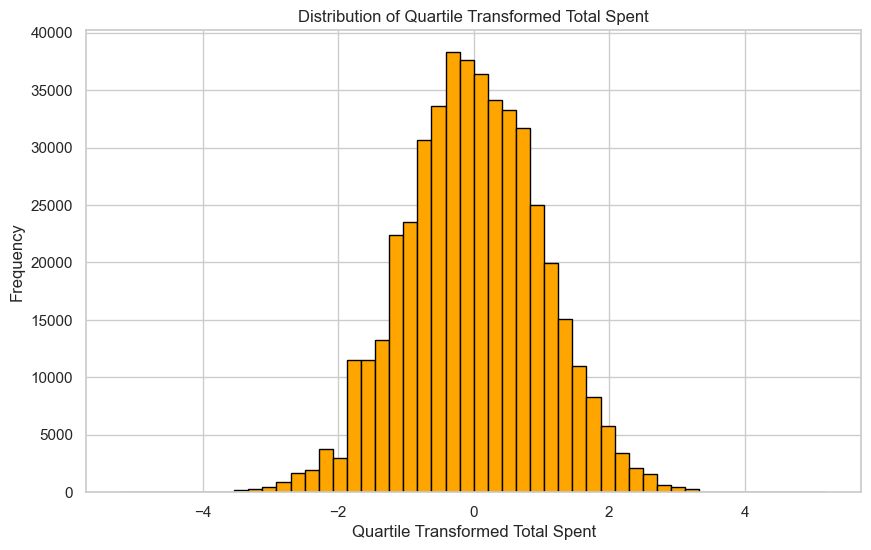

In [137]:
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer

df_for_scaling = df_c_train_fe.copy()
df_for_scaling['total_spent_log'] = np.log1p(df_for_scaling['total_spent'])

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(df_for_scaling['total_spent_log'], bins=50, color='green', edgecolor='black')
plt.title('Distribution of Log Transformed Total Spent')
plt.xlabel('Total Spent')
plt.ylabel('Frequency')
plt.show()

quantile_transformer = QuantileTransformer(output_distribution='normal')
df_for_scaling['total_spent_scaled'] = quantile_transformer.fit_transform(df_for_scaling[['total_spent_log']])

plt.figure(figsize=(10, 6))
plt.hist(df_for_scaling['total_spent_scaled'], bins=50, color='orange', edgecolor='black')
plt.title('Distribution of Quartile Transformed Total Spent')
plt.xlabel('Quartile Transformed Total Spent')
plt.ylabel('Frequency')
plt.show()

In [138]:
df_c_train_fe['total_spent_scaled'] = df_for_scaling['total_spent_scaled']
df_c_train_fe.head(5)

,customer_id,fashion_news_frequency,age,total_spent,spending_power,preferred_products,preferred_colors,preferred_perceived_colors,combined_preferences,combined_preferences_embeddings,avg_time_diff_btw_purchase,hours_between_purchases,total_transactions,avg_spent,max_spent,trend_score,log_trend_score,diversity_score,total_spent_scaled
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,None,49.0,0.111814,Medium,Garment Upper body,Black,Dark,"Garment Upper body, Black, Dark","[-0.16557673, 0.12581567, 0.18150374, -0.09454...",11 days 12:00:00,276.0,3,0.037271,0.050831,0.000316,-8.060959,0.152843,-0.139710
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,None,25.0,0.782712,High,Garment Upper body,Black,Dark,"Garment Upper body, Black, Dark","[-0.16557673, 0.12581567, 0.18150374, -0.09454...",3 days 10:06:18.947368421,82.0,20,0.039136,0.084729,0.000197,-8.531776,0.345287,1.707719
2,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,None,54.0,0.060983,Medium,Underwear,Black,Dark,"Underwear, Black, Dark","[-0.2277323, 0.51116055, 0.020547291, 0.149339...",0 days 00:00:00,8760.0,2,0.030492,0.030492,0.000082,-9.407381,0.000947,-0.672129
3,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,None,20.0,0.042339,Low,Swimwear,Dark Green,Medium Dusty,"Swimwear, Dark Green, Medium Dusty","[0.08616607, -0.1816099, 0.25200048, -0.060982...",0 days 00:00:00,8760.0,2,0.021169,0.025407,0.000269,-8.219498,0.071792,-1.053106
4,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,Regularly,56.0,0.772729,High,Garment Upper body,Black,Dark,"Garment Upper body, Black, Dark","[-0.16557673, 0.12581567, 0.18150374, -0.09454...",1 days 21:31:02.068965517,46.0,30,0.025758,0.065881,0.000111,-9.109974,0.155789,1.689458


### Differentiating hours_between_purchases via quartiles
1. Exclude "no_repurchase_hours" / 8760.0 hours first
2. Log to reduce skewness, and scale using Min-Max
3. Plot Histogram to observe distribution
4. Obtain quantiles
5. Categorise respectively into "Very Short", "Short", "Medium", "Long", "Very Long", "Never"

In [139]:
# exclude "Never", in context of not repurchasing
df_c_train_fe['repurchased_before'] = (df_c_train_fe['hours_between_purchases'] != 8760.0).astype(int)

df_repurchased = df_c_train_fe[df_c_train_fe['repurchased_before'] == 1].copy()

# Apply log transformation to reduce skewness
df_repurchased['hours_between_purchases_log'] = np.log1p(df_repurchased['hours_between_purchases'])

# Apply Min-Max scaling to preserve the shape of the dataset's distribution
scaler = MinMaxScaler()
df_repurchased['hours_between_purchases_scaled'] = scaler.fit_transform(df_repurchased[['hours_between_purchases_log']])

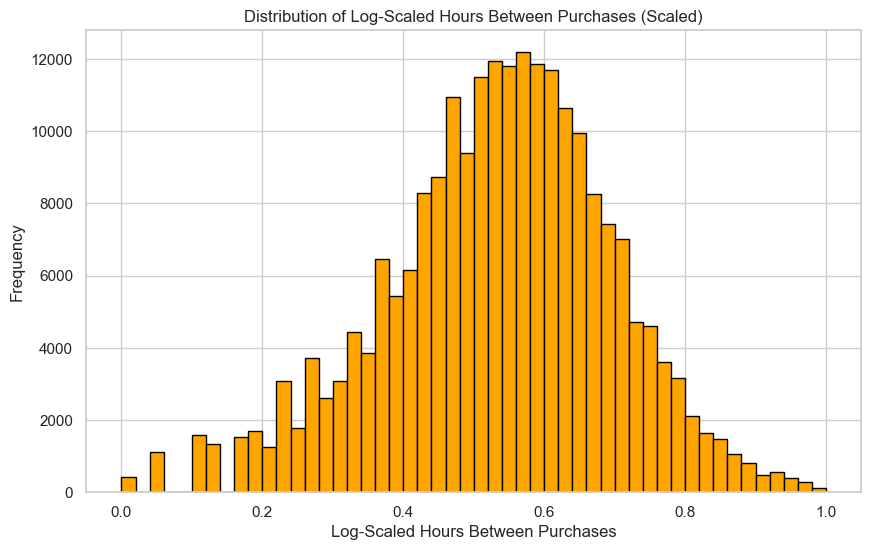

In [140]:
# plot histogram to see distribution
sns.set(style="whitegrid")

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(df_repurchased['hours_between_purchases_scaled'], bins=50, color='orange', edgecolor='black')
plt.title('Distribution of Log-Scaled Hours Between Purchases (Scaled)')
plt.xlabel('Log-Scaled Hours Between Purchases')
plt.ylabel('Frequency')
plt.show()

In [141]:
# Calculate 5 Quantiles (20th, 40th, 60th, 80th percentiles)
quantiles = df_repurchased['hours_between_purchases_scaled'].quantile([0.25, 0.50, 0.75]).to_list()
print(f"Quantile Boundaries: {quantiles}")

Quantile Boundaries: [0.43749897743316096, 0.5451481089979762, 0.6426211590707555]


In [142]:
# add all scaled values from df_for_scaling into df_c_train_fe. remember to add back 8760 (not repurchase)
df_c_train_fe = df_c_train_fe.merge(df_repurchased[['customer_id', 'hours_between_purchases_scaled']],
                                    on='customer_id', 
                                    how='left')

df_c_train_fe['hours_between_purchases_scaled'].fillna(8760, inplace=True)

In [145]:
# converts numerical hours to categories
def categorise_hours(scaled_hours):
    if scaled_hours == 8760:  # This will catch the 8760 values which are NaN in 'hours_between_purchases_scaled'
        return "Never"
    elif scaled_hours <= quantiles[0]:
        return "Short"
    elif scaled_hours <= quantiles[1]:
        return "Medium"
    elif scaled_hours <= quantiles[2]:
        return "Long"

    return "Very Long"

# apply categorization
df_c_train_fe['purchase_behaviour'] = df_c_train_fe['hours_between_purchases_scaled'].apply(categorise_hours)

# check the distribution of categories
print(df_c_train_fe['purchase_behaviour'].value_counts())

purchase_behaviour
Never        237556
Short         57808
Long          56610
Medium        55888
Very Long     55877
Name: count, dtype: int64


## Multi-Feature Clustering
1. Customer Characteristics: `'age', 'fashion_news_frequency'`

`K-Prototypes` - an extension of K-Means that can handle both numerical and categorical data, making it suitable for this mix of data types. It combines the K-Means objective function for numerical data with the K-Modes objective function for categorical data, allowing it to effectively find clusters within mixed data types.

Pro: Specifically designed for clustering mixed data types.

2. Transactional Behaviour:  `'hours_between_purchases_scaled', 'total_spent_scaled'`

`K-Means` - It means for clustering, which allows it to handle ordinal relationships via distance effectively by minimizing the dissimilarities between points in a cluster and maximizing the dissimilarities between different clusters.

Pro: Efficiently clusters data

### KPrototype for `'age', 'fashion_news_frequency'`
1. Find optimal number of clusters
2. Fit to training data
3. Plot a violin plot to visualise the relationships between two variables and the clusters

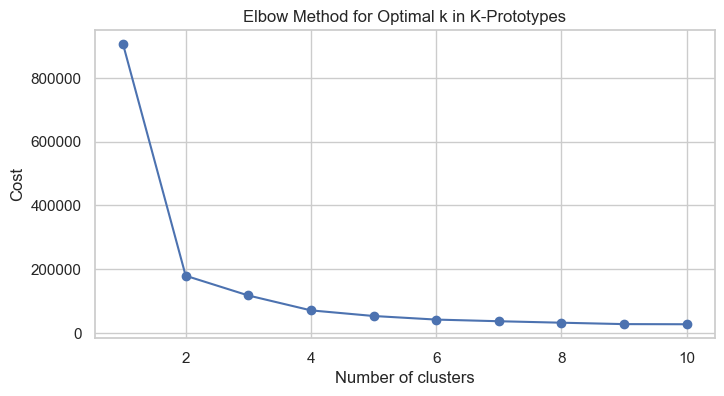

In [146]:
from kmodes.kprototypes import KPrototypes

# find optimal clusters for KProto
data = df_c_train_fe[['age', 'fashion_news_frequency']].copy()
data['fashion_news_frequency'] = data['fashion_news_frequency'].astype(str)

# random sample to improve run time
sampled_data = data.sample(frac=0.01, random_state=42)

costs = []
for k in range(1, 11):
    kproto = KPrototypes(n_clusters=k, init='Cao', n_init=3, max_iter=10, verbose=0)
    kproto.fit(sampled_data, categorical=[1])
    costs.append(kproto.cost_)

plt.figure(figsize=(8, 4))
plt.plot(range(1,11), costs, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k in K-Prototypes')
plt.show()

In [147]:
# Fit KPrototypes on the full dataset
# From above, optimal number of clusters is 2
kproto_full = KPrototypes(n_clusters=2, init='Cao', n_init=5, max_iter=10, verbose=0)
clusters_kp_full = kproto_full.fit_predict(
    df_c_train_fe[['age', 'fashion_news_frequency']],
    categorical=[1]
)

# Assign the cluster labels to the full dataset
df_c_train_fe['Customer_Characteristics_Cluster'] = clusters_kp_full

### Violin Plot to show the distribution of ages for each cluster within each `fashion_news_frequency` category. This will give us insight into the `age` distribution for each cluster and category combination.

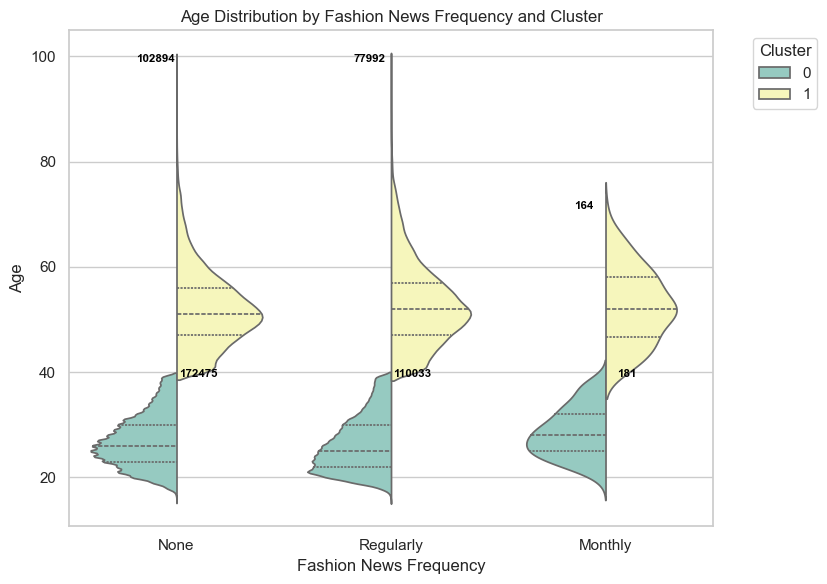

In [149]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))

# violin plot
ax = sns.violinplot(x="fashion_news_frequency", y="age", hue="Customer_Characteristics_Cluster",
                    split=True, inner="quart", palette="Set3", data=df_c_train_fe)

# labels
plt.title('Age Distribution by Fashion News Frequency and Cluster')
plt.xlabel('Fashion News Frequency')
plt.ylabel('Age')

plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc=2)

# adding frequency numbers inside the violin plot
# need to consider the hue "Customer_Characteristics_Cluster" when calculating positions
for i, group in enumerate(df_c_train_fe['fashion_news_frequency'].unique()):
    for j, cluster in enumerate(df_c_train_fe['Customer_Characteristics_Cluster'].unique()):
        position = ax.get_xticks()[i] + 0.2 * (j - 0.5)  
        subset = df_c_train_fe[(df_c_train_fe['fashion_news_frequency'] == group) &
                               (df_c_train_fe['Customer_Characteristics_Cluster'] == cluster)]
        num_observations = len(subset)
        ax.text(position, subset['age'].max(), num_observations, horizontalalignment='center', size='x-small', color='black', weight='semibold')

plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.show()

### K-Means for `'spending_power_encoded', 'purchase_behaviour_encoded'`
do-before: convert categorical features into encoded labels, to preserve ordinal nature (e.g. Low, Medium, High to 0, 1, 2)
1. Find optimal number of clusters
2. Fit to training data
3. Plot a pivot table to visualise the relationships between two categorical variables and the clusters

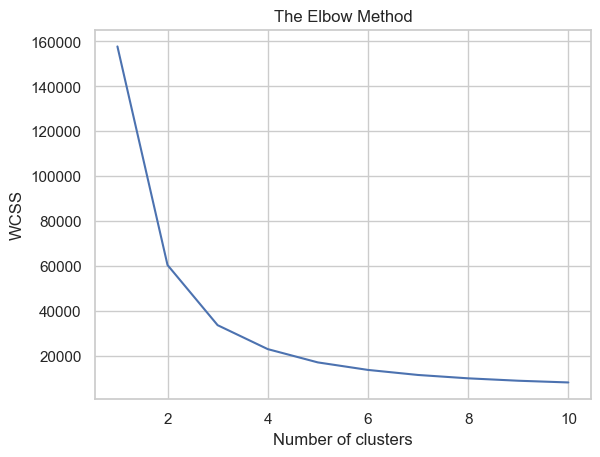

In [151]:
from sklearn.cluster import KMeans

# find optimal clusters for KModes
X = df_repurchased[['hours_between_purchases_scaled', 'total_spent_scaled']]

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=500, n_init=10, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') 
plt.show()

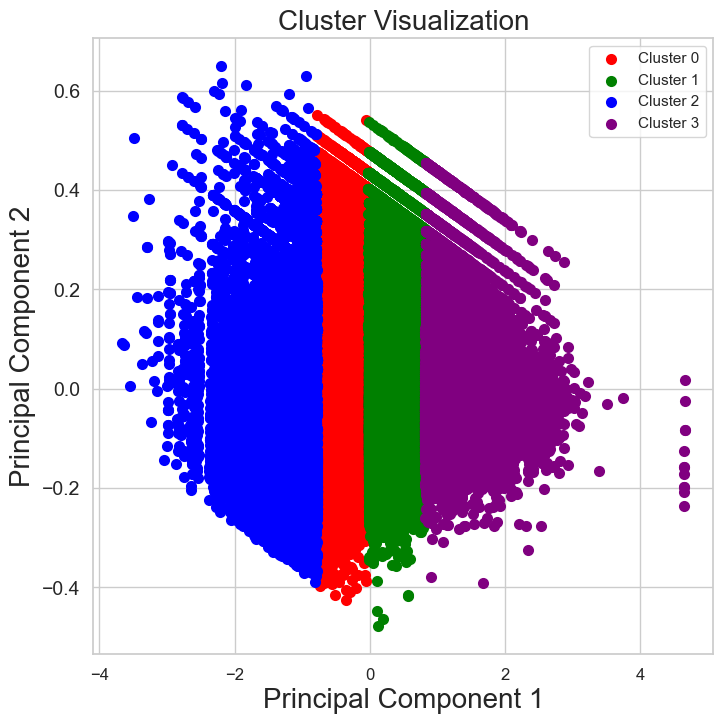

In [152]:
from sklearn.decomposition import PCA

# 'elbow' point from above
k_optimal = 4

# Perform k-means clustering
kmeans = KMeans(n_clusters=k_optimal, init='k-means++', max_iter=500, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(df_repurchased[['hours_between_purchases_scaled', 'total_spent_scaled']])

# add the cluster labels to df_c_train_fe
df_repurchased['Transactional_Behaviour_Cluster'] = cluster_labels

# visualize the clusters
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_repurchased[['hours_between_purchases_scaled', 'total_spent_scaled']])

df_principal = pd.DataFrame(data=principal_components, columns=['principal_component_1', 'principal_component_2'])

df_repurchased.reset_index(drop=True, inplace=True)
df_principal.reset_index(drop=True, inplace=True)
df_visualization = pd.concat([df_repurchased, df_principal], axis=1)

plt.figure(figsize=(8, 8))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component 1', fontsize=20)
plt.ylabel('Principal Component 2', fontsize=20)
plt.title('Cluster Visualization', fontsize=20)

colors = ['red', 'green', 'blue', 'purple']
for color, i, target_name in zip(colors, [0, 1, 2, 3], range(k_optimal)):
    plt.scatter(df_visualization.loc[df_visualization['Transactional_Behaviour_Cluster'] == i, 'principal_component_1'],
                df_visualization.loc[df_visualization['Transactional_Behaviour_Cluster'] == i, 'principal_component_2'],
                color=color, lw=2, label='Cluster ' + str(target_name))

plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.show()

In [160]:
df_c_train_fe = df_c_train_fe.merge(df_repurchased[['customer_id', 'Transactional_Behaviour_Cluster']],
                                    on='customer_id', 
                                    how='left')

# to handle customers who have not repurchased before, assign them to their own cluster
df_c_train_fe.loc[df_c_train_fe['repurchased_before'] == 0, 'Transactional_Behaviour_Cluster'] = k_optimal


In [163]:
df_c_train_fe['Transactional_Behaviour_Cluster'] = df_c_train_fe['Transactional_Behaviour_Cluster'].astype(int)
df_c_train_fe["Customer_Characteristics_Cluster"] = df_c_train_fe['Customer_Characteristics_Cluster'].astype('uint16')

In [290]:
print(df_c_train_fe['Transactional_Behaviour_Cluster'].value_counts())
print(df_c_train_fe['Customer_Characteristics_Cluster'].value_counts())

Transactional_Behaviour_Cluster
4    237556
1     77153
0     74596
2     38389
3     36045
Name: count, dtype: int64
Customer_Characteristics_Cluster
0    282689
1    181050
Name: count, dtype: int64


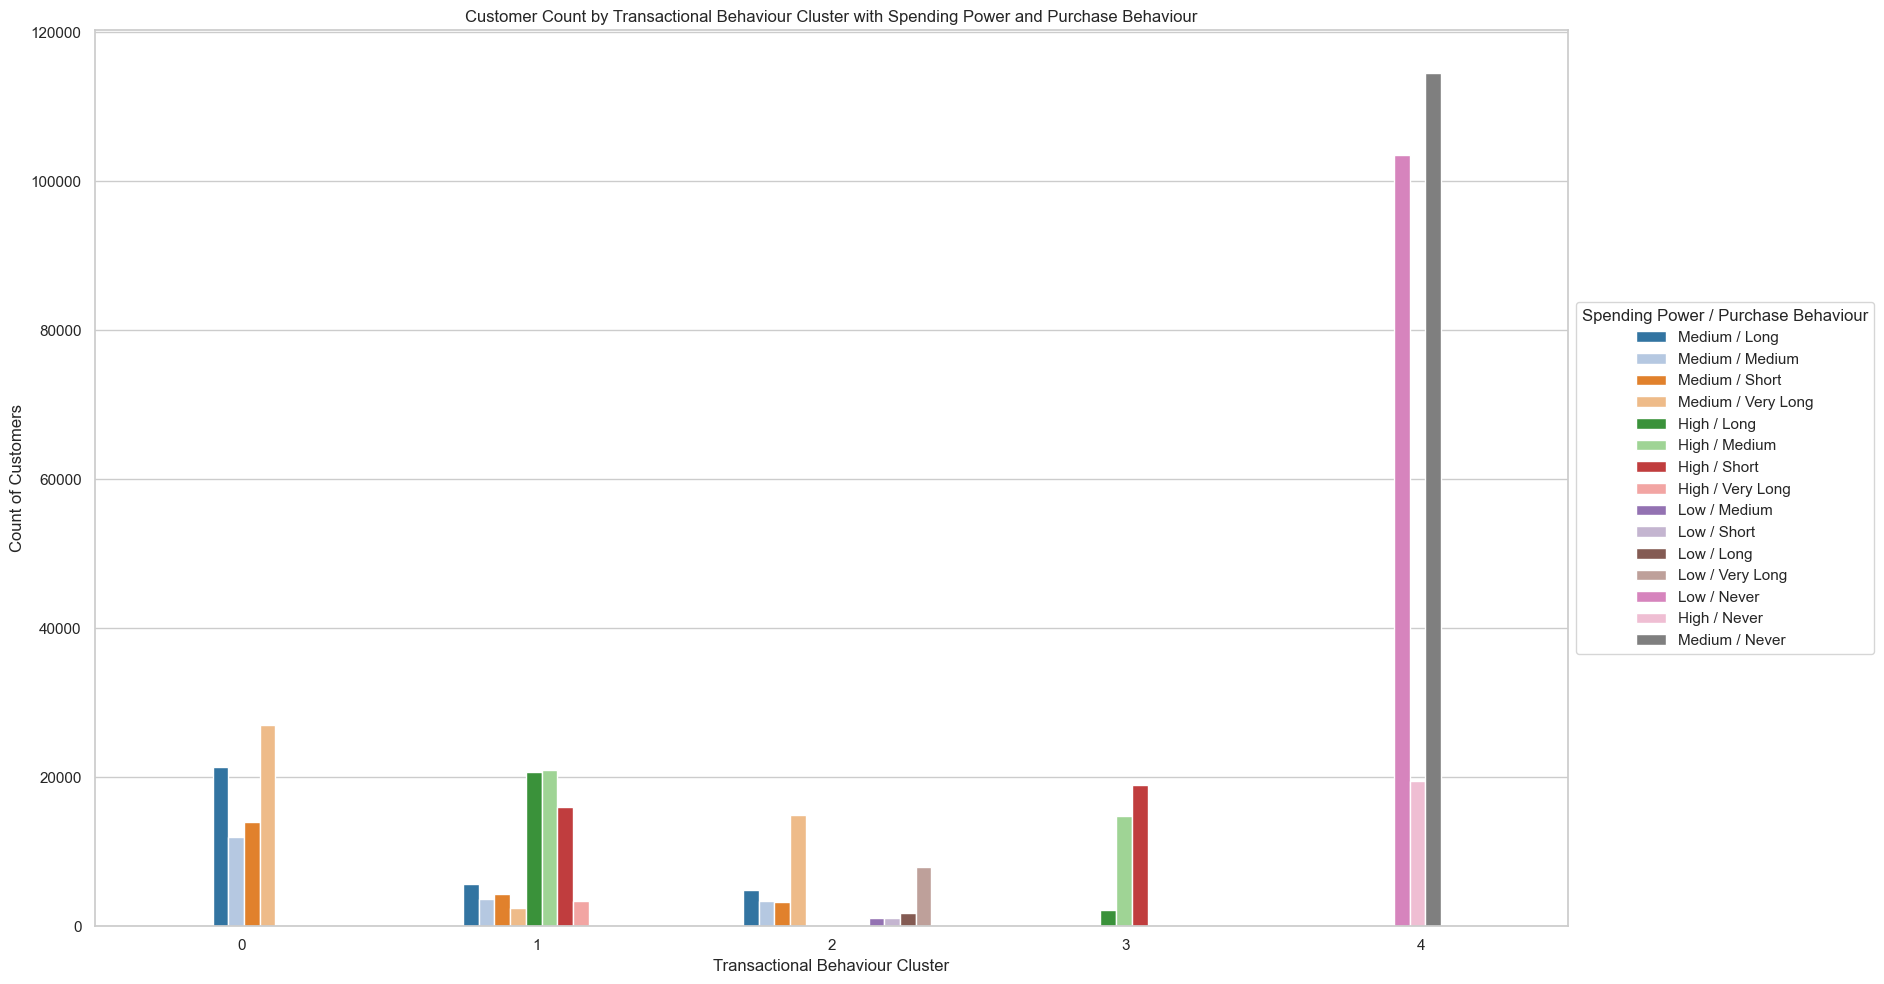

In [313]:
df_plot = df_c_train_fe.groupby(
    ['Transactional_Behaviour_Cluster', 'spending_power', 'purchase_behaviour']
).size().reset_index(name='count')

df_plot['Transactional_Behaviour_Cluster'] = df_plot['Transactional_Behaviour_Cluster'].astype(int)

# sort the dataframe by 'Transactional_Behaviour_Cluster'
df_plot.sort_values('Transactional_Behaviour_Cluster', inplace=True)

# create the combined column for hue
df_plot['spending_purchase_comb'] = df_plot['spending_power'] + ' / ' + df_plot['purchase_behaviour']

palette = sns.color_palette("tab20", 15)

plt.figure(figsize=(19, 10))

# Define the shifts for each cluster
shifts = {0: 0.3, 1: 0.15, 2: 0.1, 3: 0.1, 4: -0.33}

# Create the bar plot
barplot = sns.barplot(
    data=df_plot,
    x='Transactional_Behaviour_Cluster',
    y='count',
    hue='spending_purchase_comb',
    palette=palette
)

# adjust the position of each bar based on its cluster
for bar in barplot.patches:
    x = bar.get_x()
    width = bar.get_width()
    center = x + width / 2
    
    cluster = round(center)
    
    if cluster in shifts:
        new_center = center + shifts[cluster]
        bar.set_x(new_center - width / 2)

plt.title('Customer Count by Transactional Behaviour Cluster with Spending Power and Purchase Behaviour')
plt.xlabel('Transactional Behaviour Cluster')
plt.ylabel('Count of Customers')

plt.legend(title='Spending Power / Purchase Behaviour', loc='center left', bbox_to_anchor=(1, 0.5))

cluster_labels = df_plot['Transactional_Behaviour_Cluster'].sort_values().unique()
plt.xticks(ticks=range(len(cluster_labels)), labels=cluster_labels)

plt.tight_layout()
plt.show()

In [317]:
df_c_train_fe = df_c_train_fe.drop(columns=['spending_purchase_comb'])
df_c_train_fe.head(5)

,customer_id,fashion_news_frequency,age,total_spent,spending_power,preferred_products,preferred_colors,preferred_perceived_colors,combined_preferences,combined_preferences_embeddings,...,max_spent,trend_score,log_trend_score,diversity_score,total_spent_scaled,repurchased_before,hours_between_purchases_scaled,purchase_behaviour,Customer_Characteristics_Cluster,Transactional_Behaviour_Cluster
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,None,49.0,0.111814,Medium,Garment Upper body,Black,Dark,"Garment Upper body, Black, Dark","[-0.16557673, 0.12581567, 0.18150374, -0.09454...",...,0.050831,0.000316,-8.060959,0.152843,-0.139710,1,0.726246,Very Long,1,0
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,None,25.0,0.782712,High,Garment Upper body,Black,Dark,"Garment Upper body, Black, Dark","[-0.16557673, 0.12581567, 0.18150374, -0.09454...",...,0.084729,0.000197,-8.531776,0.345287,1.707719,1,0.548741,Long,0,3
2,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,None,54.0,0.060983,Medium,Underwear,Black,Dark,"Underwear, Black, Dark","[-0.2277323, 0.51116055, 0.020547291, 0.149339...",...,0.030492,0.000082,-9.407381,0.000947,-0.672129,0,8760.000000,Never,1,4
3,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,None,20.0,0.042339,Low,Swimwear,Dark Green,Medium Dusty,"Swimwear, Dark Green, Medium Dusty","[0.08616607, -0.1816099, 0.25200048, -0.060982...",...,0.025407,0.000269,-8.219498,0.071792,-1.053106,0,8760.000000,Never,0,4
4,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,Regularly,56.0,0.772729,High,Garment Upper body,Black,Dark,"Garment Upper body, Black, Dark","[-0.16557673, 0.12581567, 0.18150374, -0.09454...",...,0.065881,0.000111,-9.109974,0.155789,1.689458,1,0.464980,Medium,1,3


In [318]:
df_c_train_fe_final = df_c_train_fe[['customer_id', 'Customer_Characteristics_Cluster', 'Transactional_Behaviour_Cluster']]
df_c_train_fe_final.head(5)

,customer_id,Customer_Characteristics_Cluster,Transactional_Behaviour_Cluster
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,1,0
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0,3
2,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,1,4
3,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,0,4
4,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,1,3


In [34]:
df_c_train_fe.to_pickle(os.path.join(os.getcwd(),'data', 'df_c_train_MIDWAY.pkl'))
df_c_train_fe_final.to_pickle(os.path.join(os.getcwd(),'data', 'df_c_train_cs.pkl'))

## EDA to find Customer Lifetime Value 

- Using Average Spendings and Average Transactions Counts and categorise clusters into customer relationship groups 

- Outcome : Determine value of customers to H&M

- Assuming all other variables remained constant (eg. identical retention rate, lifespan etc. for all customers)

In [55]:
df_clv_cs = pd.read_pickle('data/df_c_train_MIDWAY.pkl')
df_clv_cs.head(5)

,customer_id,fashion_news_frequency,age,total_spent,spending_power,preferred_products,preferred_colors,preferred_perceived_colors,combined_preferences,combined_preferences_embeddings,...,max_spent,trend_score,log_trend_score,diversity_score,total_spent_scaled,repurchased_before,hours_between_purchases_scaled,purchase_behaviour,Customer_Characteristics_Cluster,Transactional_Behaviour_Cluster
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,None,49.0,0.111814,Medium,Garment Upper body,Black,Dark,"Garment Upper body, Black, Dark","[-0.16557673, 0.12581567, 0.18150374, -0.09454...",...,0.050831,0.000316,-8.060959,0.152843,-0.139710,1,0.726246,Very Long,1,0
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,None,25.0,0.782712,High,Garment Upper body,Black,Dark,"Garment Upper body, Black, Dark","[-0.16557673, 0.12581567, 0.18150374, -0.09454...",...,0.084729,0.000197,-8.531776,0.345287,1.707719,1,0.548741,Long,0,3
2,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,None,54.0,0.060983,Medium,Underwear,Black,Dark,"Underwear, Black, Dark","[-0.2277323, 0.51116055, 0.020547291, 0.149339...",...,0.030492,0.000082,-9.407381,0.000947,-0.672129,0,8760.000000,Never,1,4
3,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,None,20.0,0.042339,Low,Swimwear,Dark Green,Medium Dusty,"Swimwear, Dark Green, Medium Dusty","[0.08616607, -0.1816099, 0.25200048, -0.060982...",...,0.025407,0.000269,-8.219498,0.071792,-1.053106,0,8760.000000,Never,0,4
4,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,Regularly,56.0,0.772729,High,Garment Upper body,Black,Dark,"Garment Upper body, Black, Dark","[-0.16557673, 0.12581567, 0.18150374, -0.09454...",...,0.065881,0.000111,-9.109974,0.155789,1.689458,1,0.464980,Medium,1,3


### Examining `total_spent` and `average_log_spent_per_customer` within respective clusters
And also finding the average logged spent per customers among the clusters

C:\Users\nicho\AppData\Local\Temp\ipykernel_28560\2256284974.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  median_spending_per_customer_per_cluster = df_clv_cs.groupby('Transactional_Behaviour_Cluster').apply(lambda x: np.median(x['total_spent']))


Transactional_Behaviour_Cluster
0    12014.184237
1    27892.507390
2     2697.945864
3    35415.708254
4    26443.911441
Name: total_spent, dtype: float64
Transactional_Behaviour_Cluster
0    0.158695
1    0.343932
2    0.072831
3    0.823305
4    0.067780
dtype: float64
Mean Spendings Made Across The Clusters:  0.29330847457627074


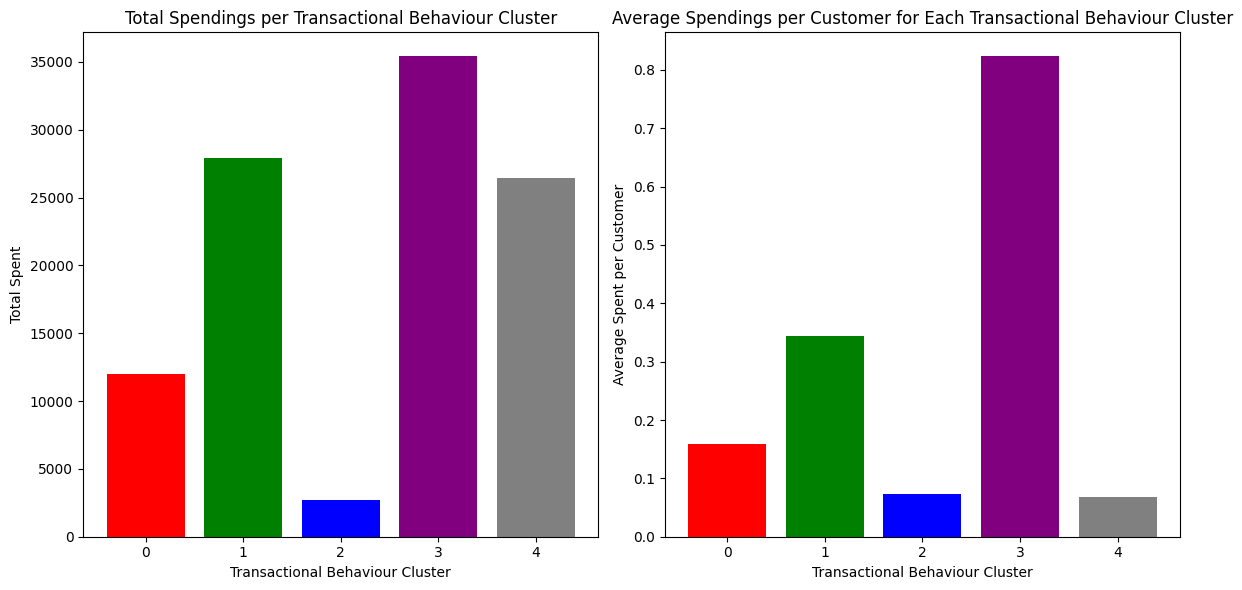

In [59]:
colors = {0: 'red', 1: 'green', 2: 'blue', 3: 'purple', 4:'grey'}

cluster_total_spendings = df_clv_cs.groupby('Transactional_Behaviour_Cluster')['total_spent'].sum()
median_spending_per_customer_per_cluster = df_clv_cs.groupby('Transactional_Behaviour_Cluster').apply(lambda x: np.median(x['total_spent']))

print(cluster_total_spendings)
print(median_spending_per_customer_per_cluster)
mean_cluster_spendings = median_spending_per_customer_per_cluster.sum() / 5
print("Mean Spendings Made Across The Clusters: " , mean_cluster_spendings)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot total spendings
data_total = cluster_total_spendings.reset_index()
cluster_colors_total = data_total['Transactional_Behaviour_Cluster'].map(colors)
axs[0].bar(data_total['Transactional_Behaviour_Cluster'], data_total['total_spent'], color=cluster_colors_total)
axs[0].set_xlabel('Transactional Behaviour Cluster')
axs[0].set_ylabel('Total Spent')
axs[0].set_title('Total Spendings per Transactional Behaviour Cluster')
axs[0].set_xticks(data_total['Transactional_Behaviour_Cluster'])

# Plot average spendings per customer
axs[1].bar(median_spending_per_customer_per_cluster.index, median_spending_per_customer_per_cluster.values, color=[colors[cluster] for cluster in median_spending_per_customer_per_cluster.index])
axs[1].set_xlabel('Transactional Behaviour Cluster')
axs[1].set_ylabel('Average Spent per Customer')
axs[1].set_title('Average Spendings per Customer for Each Transactional Behaviour Cluster')
axs[1].set_xticks(median_spending_per_customer_per_cluster.index)


plt.tight_layout()
plt.show()


### From the total spending plot, we can see that Cluster 3 has the highest total spending and Cluster 2 has the lowest total spending

### However, from the average spending plot, we now observe that Cluster 3 again has the highest average spending and Cluster 4 now has the lowest average spending

### Cluster 0 show a below-average level of average spendings per customer, while Cluster 1 performs above-average.

Most notably, Cluster 4 who boast a impressive total spendings has surprisingly low average spendings. 

This can be explained due to its high volume of customers at 237556 which is almost **4 times** more than any other clusters, but in reality these customers do not return to repurchase much and the transactions sum are low everytime.

Transactional_Behaviour_Cluster
0     6.0
1    12.0
2     3.0
3    27.0
4     3.0
dtype: float64
Mean Transactions Made Across The Clusters:  10.2


C:\Users\nicho\AppData\Local\Temp\ipykernel_28560\2824930084.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  median_transaction_per_customer_per_cluster = df_clv_cs.groupby('Transactional_Behaviour_Cluster').apply(lambda x: np.median(x['total_transactions']))


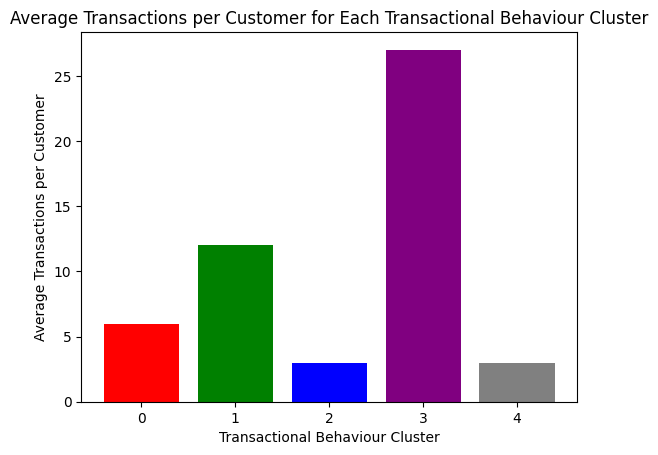

In [60]:
median_transaction_per_customer_per_cluster = df_clv_cs.groupby('Transactional_Behaviour_Cluster').apply(lambda x: np.median(x['total_transactions']))
print(median_transaction_per_customer_per_cluster)
mean_cluster_transanctions_count = median_transaction_per_customer_per_cluster.sum() / 5
print("Mean Transactions Made Across The Clusters: " , mean_cluster_transanctions_count)
plt.bar(median_transaction_per_customer_per_cluster.index, median_transaction_per_customer_per_cluster.values, color=[colors[cluster] for cluster in median_transaction_per_customer_per_cluster.index])
plt.xlabel('Transactional Behaviour Cluster')
plt.ylabel('Average Transactions per Customer')
plt.title('Average Transactions per Customer for Each Transactional Behaviour Cluster')
plt.xticks(median_transaction_per_customer_per_cluster.index)

plt.show()

### Similarly to the average spending plot, the average transactions plot shows that Cluster 3 exhibits the highest average number of transactions per customer, while Cluster 2 and 4 demonstrates the lowest average. Cluster 0 show a below-average level of average transactions per customer, while Cluster 1 performs above-average.

### 4 Types of Customer Relationship Groups

- True Friends: High average spending & High average number of transactions

- Butterflies: High average spending & Low average number of transactions

- Barnacles: Low average spending & High average number of transactions

- Strangers: Low average spending & Low average number of transactions

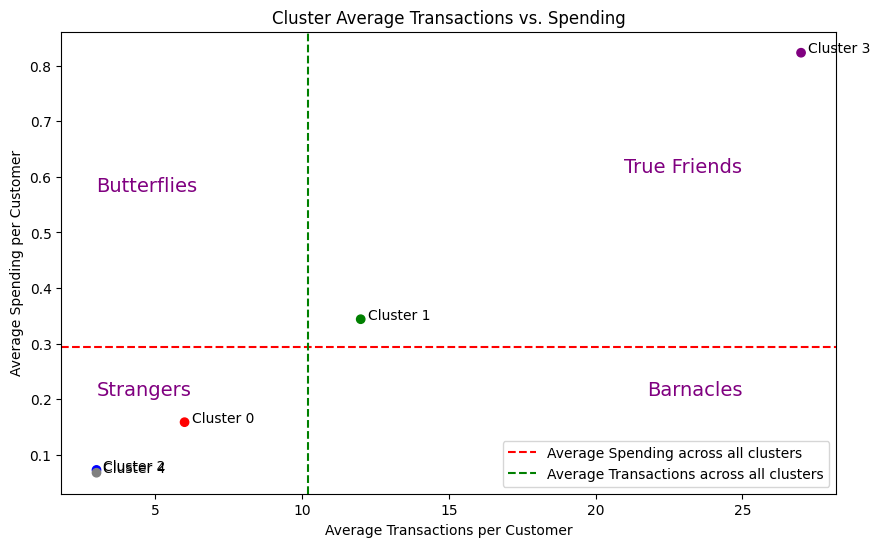

In [69]:
# Sample data
avg_spending = median_spending_per_customer_per_cluster.values
avg_transactions = median_transaction_per_customer_per_cluster.values

# Mean values
mean_spending = mean_cluster_spendings
mean_transactions = mean_cluster_transanctions_count

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(avg_transactions, avg_spending, color=[colors[i] for i in range(len(avg_spending))])

# Adding labels for each point
clusters = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']
for i, txt in enumerate(clusters):
    plt.annotate(txt, (avg_transactions[i], avg_spending[i]), xytext=(5, 0), textcoords='offset points')

# Draw lines for mean values
plt.axhline(y=mean_spending, color='r', linestyle='--', label=f'Average Spending across all clusters')
plt.axvline(x=mean_transactions, color='g', linestyle='--', label=f'Average Transactions across all clusters')

# Annotate corners
plt.text(25, 0.6, 'True Friends', verticalalignment='bottom', horizontalalignment='right', fontsize=14, color='purple')
plt.text(3, 0.6, 'Butterflies', verticalalignment='top', horizontalalignment='left', fontsize=14, color='purple')
plt.text(3, 0.2, 'Strangers', verticalalignment='bottom', horizontalalignment='left', fontsize=14, color='purple')
plt.text(25, 0.2, 'Barnacles', verticalalignment='bottom', horizontalalignment='right', fontsize=14, color='purple')

# Setting up plot labels and title
plt.xlabel('Average Transactions per Customer')
plt.ylabel('Average Spending per Customer')
plt.title('Cluster Average Transactions vs. Spending')
plt.legend()

# Show the plot
plt.show()

### A look into how the various clusters affect H&M's total spendings and transaction numbers

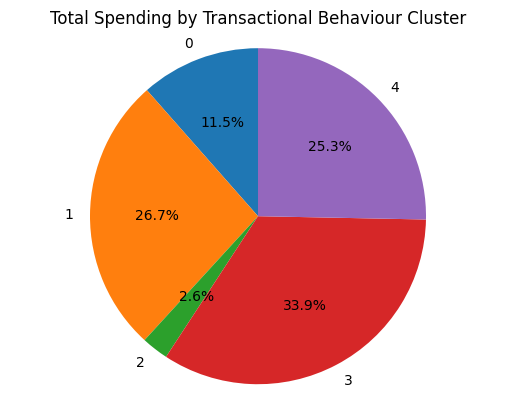

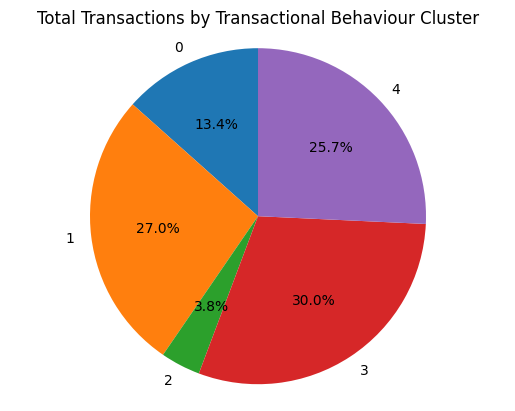

In [71]:
# Example data aggregation
grouped = df_clv_cs.groupby('Transactional_Behaviour_Cluster').agg({
    'total_spent': 'sum',
    'total_transactions': 'sum'
}).reset_index()

# Function to plot pie chart
def plot_pie(data, column, title):
    fig, ax = plt.subplots()
    ax.pie(data[column], labels=data['Transactional_Behaviour_Cluster'], autopct='%1.1f%%', startangle=90)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(title)
    plt.show()

# Plot pie chart for Total Spending
plot_pie(grouped, 'total_spent', 'Total Spending by Transactional Behaviour Cluster')

# Plot pie chart for Total Transactions
plot_pie(grouped, 'total_transactions', 'Total Transactions by Transactional Behaviour Cluster')


## Business Insights

#### From the scatter plot above, we can see that the clusters are well separated based on the average spending and transactions per customer. The groups are as follows:

##### Strong Strangers (Cluster 0):

- Recommend **similar** items based on their past purchases to strengthen their loyalty and trust.
- Prioritize targeted marketing efforts to further increase brand awareness and familiarity.
- Offer special discounts or incentives to incentivize their more returning transactions and build a connection.

##### Weak True Friends (Cluster 1):
- Recommend **similar** items based on their past purchases to strengthen their loyalty and trust.
- Prioritize personalized recommendations and exclusive deals to encourage repeat purchases and deepen the relationship.
- Offer early access to new collections or limited-edition items to make them feel valued and appreciated.

##### Strong True Friends (Cluster 3):

- ***Highest Customer Lifetime Value Cluster, biggest focal group providing 30% of all spendings & 33.9% of all transactions***
- Recommend **novel** items based on their past purchases and preferences to maintain their engagement.
- Prioritize personalized recommendations and exclusive perks to reinforce their loyalty and make them feel special.
- Offer priority access to new collections or exclusive events as a token of appreciation for their valuable patronage.
- Identify the products that are consistently popular among this group and ensure sufficient stock availability to meet demands.

##### Weak Strangers (Cluster 2 & 4):

- ***Lowest Customer Lifetime Value Cluster, but cannot be neglected as they combine for 27.9% of all spendings & 29.5% of all transactions***
- Recommend **novel** items based on their past purchases and preferences to pique their interest
- Utilise digital channels and social media platforms as cost-effective advertising instead of investing heavily in aggressive marketing campaigns due to potential low churn rate
- Offer incentives or promotions to encourage their first purchase and establish a connection with the brand.



## Delving into product management

In [72]:
df_transactions = pd.read_pickle('data/df_t_train.pkl')
df_transactions_final = df_transactions[['customer_id', 'article_id', 'price']]
df_clv_cs = df_clv_cs[["customer_id", "Transactional_Behaviour_Cluster"]]

In [74]:
df_transactions_final = pd.merge(df_transactions_final, df_clv_cs, on='customer_id', how='inner')

In [75]:
df_articles = pd.read_csv('data/articles.csv')
df_articles_final = df_articles[['article_id', 'product_type_name']]
df_transactions_final = pd.merge(df_transactions_final, df_articles_final, on='article_id', how='inner')
df_transactions_final.head(5)

,customer_id,article_id,price,Transactional_Behaviour_Cluster,product_type_name
0,000747860042b94e85707605c2a627c6ba30c4117d025d...,732725002,0.050831,1,Dress
1,001021122bdb55ec4235f35eb50164c268ec7c4bcfff90...,697060014,0.025407,3,Blouse
2,001021122bdb55ec4235f35eb50164c268ec7c4bcfff90...,758200004,0.067780,3,Blouse
3,0021ce2be745fe55f9b2bc784dbfd0e374c315ccd15aab...,769965001,0.042356,3,Dress
4,0021ce2be745fe55f9b2bc784dbfd0e374c315ccd15aab...,709269004,0.042356,3,Dress


### Proportion of product types bought by various cluster customers

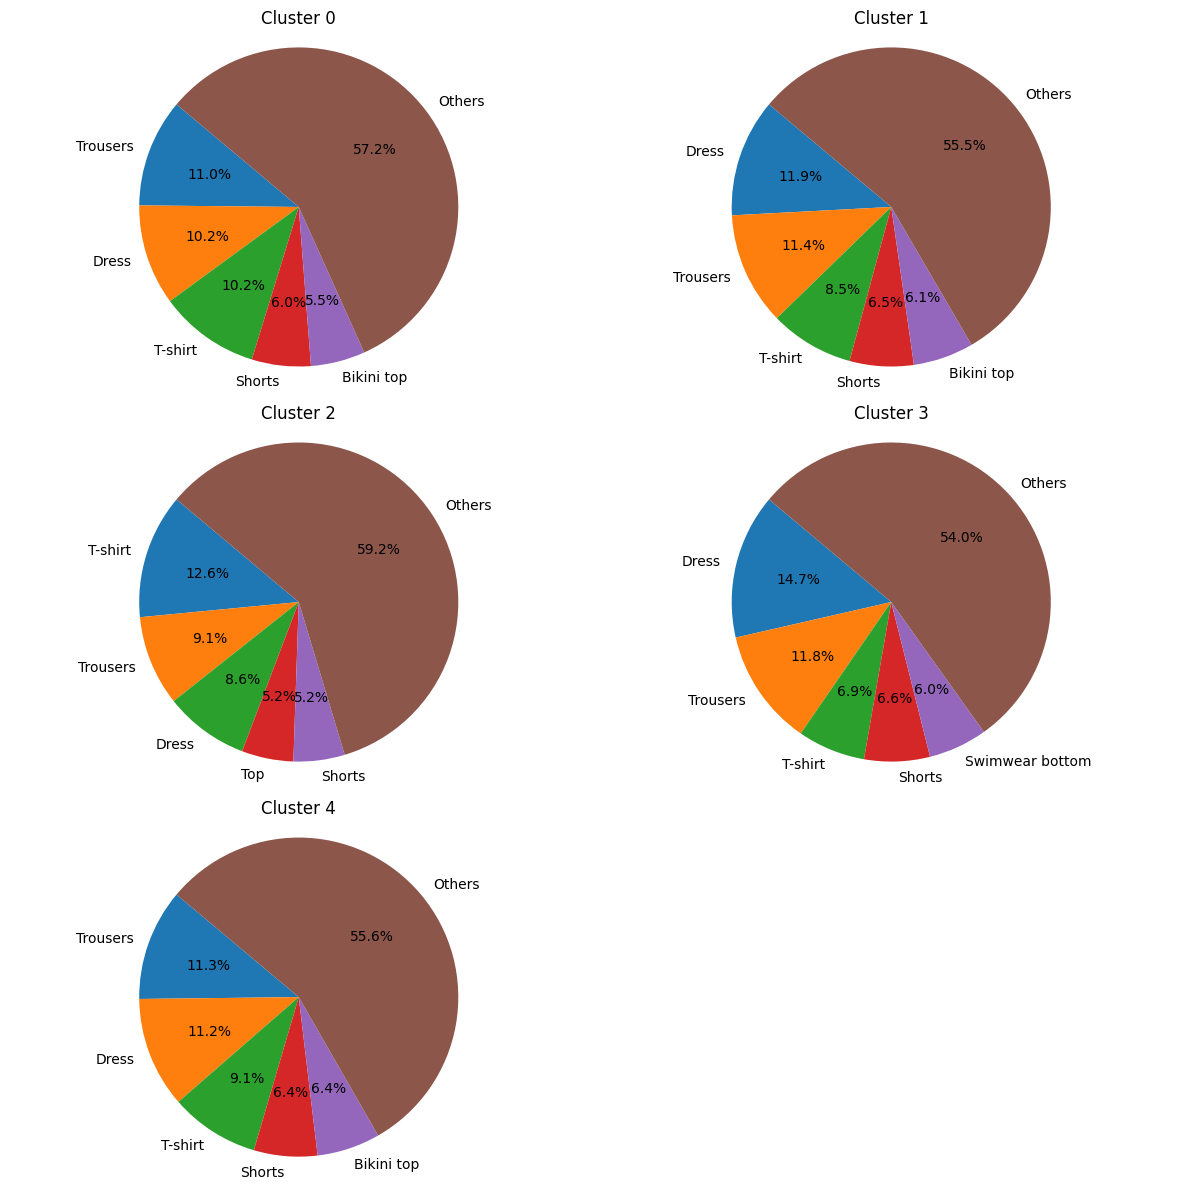

In [122]:
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
top_5_products_lists = []

for cluster_value, ax in zip(range(5), axs.flatten()):
    # Filter data for the current cluster value
    data = df_transactions_final[df_transactions_final['Transactional_Behaviour_Cluster'] == cluster_value]
    
    # Count the occurrences of each preferred product for the current cluster
    preferred_products_count = data['product_type_name'].value_counts()
    preferred_products_count = preferred_products_count.drop("Vest top")
    
    # Take the top 5 products and combine the rest into 'Others'
    top_5_products = preferred_products_count.head(5)
    top_5_products_tolist = top_5_products.index.tolist()
    top_5_products_lists.append(top_5_products)
    others_count = preferred_products_count[4:].sum()
    top_5_products['Others'] = others_count
    
    # Calculate the number of products
    num_products = len(top_5_products)
    
    # Calculate the figure size based on the number of products
    figsize = (num_products * 2, num_products * 2)
    
    # Create a pie chart
    ax.pie(top_5_products, labels=top_5_products.index, autopct='%1.1f%%', startangle=140)
    ax.set_title(f'Cluster {cluster_value}')
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
axs[2, 1].axis('off')
# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [123]:
cluster0_data = {
    "Product Type": ["Trousers", "Dress", "T-shirt", "Shorts", "Bikini top"],
}

cluster1_data = {
    "Product Type": ["Dress", "Trousers", "T-shirt", "Shorts", "Bikini top"],
}

cluster2_data = {
    "Product Type": ["T-shirt", "Trousers", "Dress", "Top", "Shorts"],
}

cluster3_data = {
    "Product Type": ["Dress", "Trousers", "T-shirt", "Shorts", "Swimwear bottom"],
}

cluster4_data = {
    "Product Type": ["Trousers", "Dress", "T-shirt", "Shorts", "Bikini top"],
}

# Convert dictionaries to DataFrames
cluster0_df = pd.DataFrame(cluster0_data)
cluster1_df = pd.DataFrame(cluster1_data)
cluster2_df = pd.DataFrame(cluster2_data)
cluster3_df = pd.DataFrame(cluster3_data)
cluster4_df = pd.DataFrame(cluster4_data)

# Remove the "Others" category
cluster0_df = cluster0_df[cluster0_df['Product Type'] != 'Others']
cluster1_df = cluster1_df[cluster1_df['Product Type'] != 'Others']
cluster2_df = cluster2_df[cluster2_df['Product Type'] != 'Others']
cluster3_df = cluster3_df[cluster3_df['Product Type'] != 'Others']
cluster4_df = cluster4_df[cluster4_df['Product Type'] != 'Others']

### Calculating the profits generated by the different types bought by various cluster customers

In [124]:
# Define a function to calculate total profits for each product type in a cluster
def calculate_total_profits(cluster_df, df_transactions_final_cluster):
    for product_type in cluster_df['Product Type']:
        # Initialize total profits for the product type
        total_profit = 0
        # Filter transactions for the current product type
        product_transactions = df_transactions_final_cluster[df_transactions_final_cluster['product_type_name'] == product_type]
        # Sum up the profits for all transactions of the product type
        total_profit = product_transactions['price'].sum()

        # Update the Total Profits column for the current product type
        cluster_df.loc[cluster_df['Product Type'] == product_type, 'Total Profits'] = total_profit

# Call the function for each cluster
df_transactions_final_cluster0 = df_transactions_final[df_transactions_final['Transactional_Behaviour_Cluster'] == 0]
df_transactions_final_cluster1 = df_transactions_final[df_transactions_final['Transactional_Behaviour_Cluster'] == 1]
df_transactions_final_cluster2 = df_transactions_final[df_transactions_final['Transactional_Behaviour_Cluster'] == 2]
df_transactions_final_cluster3 = df_transactions_final[df_transactions_final['Transactional_Behaviour_Cluster'] == 3]
df_transactions_final_cluster4 = df_transactions_final[df_transactions_final['Transactional_Behaviour_Cluster'] == 4]
calculate_total_profits(cluster0_df, df_transactions_final_cluster0)
calculate_total_profits(cluster1_df, df_transactions_final_cluster1)
calculate_total_profits(cluster2_df, df_transactions_final_cluster2)
calculate_total_profits(cluster3_df, df_transactions_final_cluster3)
calculate_total_profits(cluster4_df, df_transactions_final_cluster4)

cluster0_df = cluster0_df.sort_values(by='Total Profits')
cluster1_df = cluster1_df.sort_values(by='Total Profits')
cluster2_df = cluster2_df.sort_values(by='Total Profits')
cluster3_df = cluster3_df.sort_values(by='Total Profits')
cluster4_df = cluster4_df.sort_values(by='Total Profits')

### Comparing the different product types based on their profitability

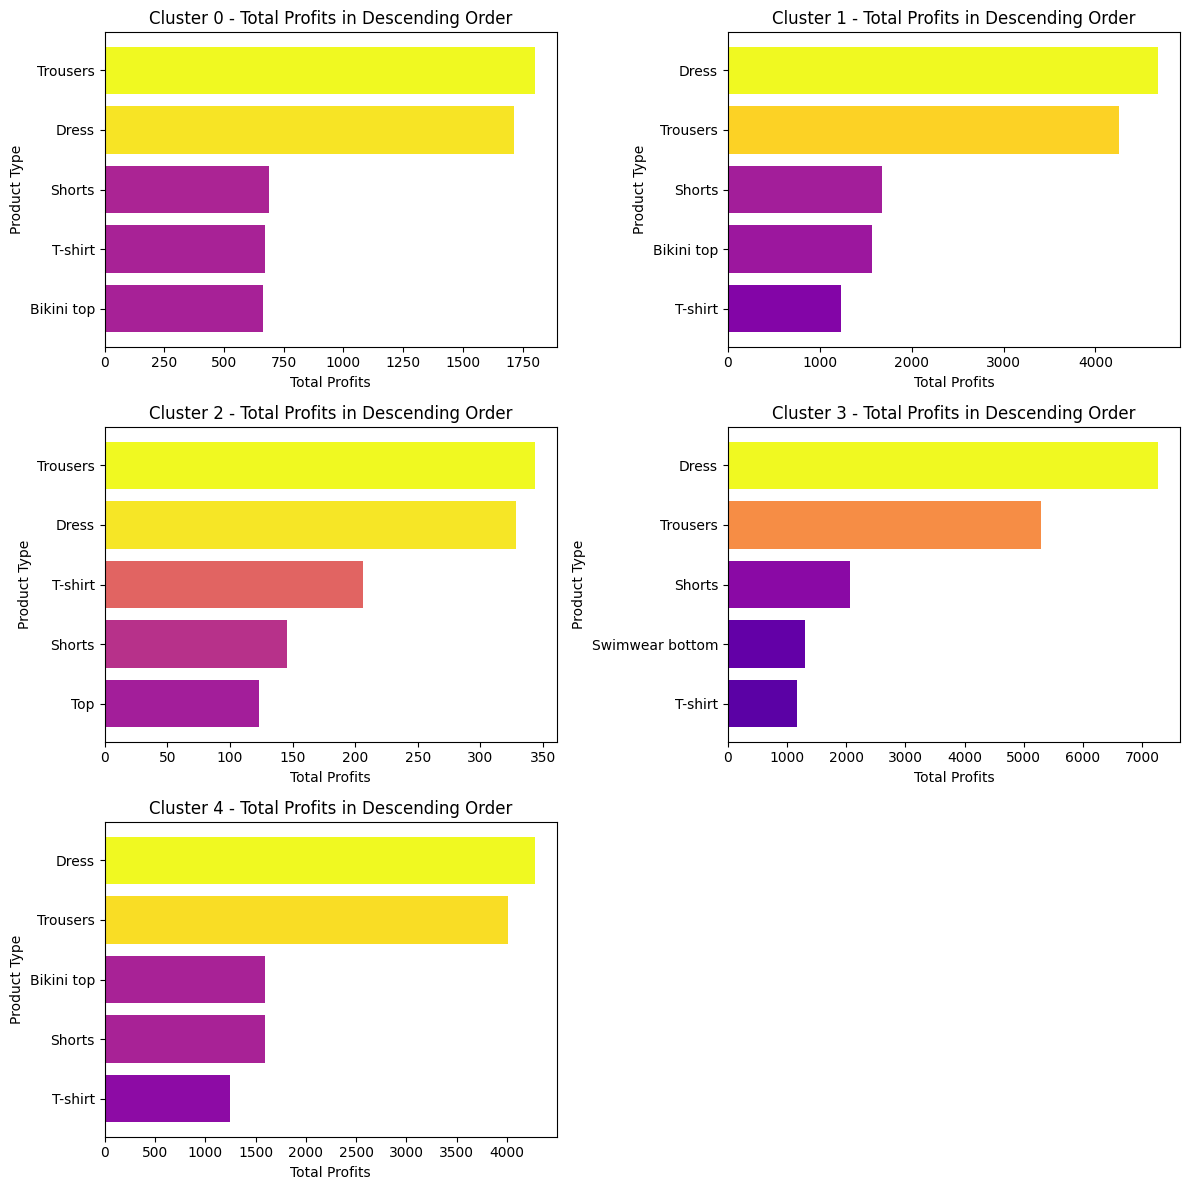

In [125]:
import matplotlib.cm as cm
def plot_profits(cluster_df, cluster_number, ax):
    colors = cm.plasma(cluster_df['Total Profits'] / max(cluster_df['Total Profits']))
    # Plot Total Profits
    ax.barh(cluster_df['Product Type'], cluster_df['Total Profits'], color=colors)
    ax.set_xlabel('Total Profits')
    ax.set_ylabel('Product Type')
    ax.set_title(f'Cluster {cluster_number} - Total Profits in Descending Order')

fig, axs = plt.subplots(3, 2, figsize=(12, 12))

# Plot profits for each cluster
plot_profits(cluster0_df, 0, axs[0, 0])
plot_profits(cluster1_df, 1, axs[0, 1])
plot_profits(cluster2_df, 2, axs[1, 0])
plot_profits(cluster3_df, 3, axs[1, 1])
plot_profits(cluster4_df, 4, axs[2, 0])
axs[2, 1].axis('off')
plt.tight_layout()
plt.show()



### - Insight: Dress and Trousers emerge as the top two most profitable items across all customer segments.

- Implications:

    - Market Focus: Direct marketing efforts towards promoting Dress and Trousers, emphasizing their features and versatility.
    - Inventory Management: Ensure adequate stock levels for Dress and Trousers to meet demand and prevent stockouts or overstock situations.
    - Product Development: Invest in expanding the variety and designs of Dress and Trousers to cater to diverse customer preferences.
    - Cross-Selling: Leverage the popularity of Dress and Trousers to promote complementary products and accessories.

### Ranking of products based on number of appearances and relative order across the 5 clusters
1.  Dress
2.  Trousers
3.  Shorts
4.  T-Shirt
5.  Bikini Top